In [1]:
import sys
import time
import numpy as np
import pandas as pd
sys.path.append("..")
from scipy import stats
from tma.model import Model
from tma.object import Object
from tma.functions import get_df
from tma.algorithms import swarm
from pathlib import Path
from datetime import datetime

Создаем модель наблюдателя:

In [7]:
print("Время последнего моделирования:", datetime.now().strftime("%d/%m/%Y %H:%M\n"))

observer_x, observer_y, observer_course, observer_velocity = 0., 0., 0., 5.
observer = Object('Наблюдатель', observer_x, observer_y, observer_course,
                observer_velocity, verbose=True)

observer.forward_movement(3 * 60)
observer.change_course(270, 'left', omega=0.5)
observer.forward_movement(5 * 60)
observer.change_course(90, 'right', omega=0.5)
observer.forward_movement(3 * 60)

Время последнего моделирования: 26/04/2021 00:36

Наблюдатель движется прямо по курсу 0.0° 180с
Наблюдатель перешёл на курс 270.0° за 180с
Наблюдатель движется прямо по курсу 270.0° 300с
Наблюдатель перешёл на курс 90.0° за 360с
Наблюдатель движется прямо по курсу 90.0° 180с


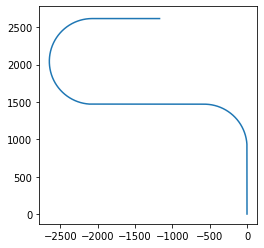

In [8]:
from tma.plot import plot_trajectory
plot_trajectory(observer)

Задаем априорные данные, вектор дистанций, вектор СКО, алгоритмы для сравнения

In [3]:
p0 = [0., 25., 90., 7.]
d_arr = [10., 20., 30., 40.]
std_arr = [0., 0.1, 0.2, 0.3, 0.5, 1.]
alg_arr = ['ММП', 'Метод N пеленгов']
def target_func(seed=None):
            np.random.seed(seed)
            b = 0
            c = np.random.uniform(0, 180)
            v = np.random.uniform(3, 15)
            return [b, target_func.d, c, v]
result_df = pd.DataFrame(columns=['Algorithm', 'std', 'd', 'sr_0', 'sr_1', 'sr_2', 'sr_3', 'Ка', 'Nf', 'Nf_max', 'Iter', 'Iter_max', 't', 't_max'])
mean_columns = ['Ка', 'Nf', 'Iter', 't']
max_columns = ['Nf', 'Iter', 't']

In [4]:
model = Model(observer)
for d in d_arr:
    target_func.d = d
    for std in std_arr:
        model.noise_std = np.radians(std)
        for alg in alg_arr:
            dict_results = swarm(model, algorithm_name=alg, n=100, target_func=target_func, p0=p0, seeded=True)
            df = get_df(dict_results)
            res = pd.DataFrame({'Algorithm': [alg], 'std': [std], 'd': [d]})
            for i in range(4):
                res['sr_' + str(i)] = [df['Успех'].apply(lambda x: x[i]).mean(axis=0)]
            res[mean_columns] = df[mean_columns].mean(axis=0)
            res[['Nf_max', 'Iter_max', 't_max']] = df[max_columns].apply(max, axis=0)
            result_df = result_df.append(res)

In [5]:
result_df['Ка'] = result_df['Ка'].apply(np.sqrt)
result_df.rename(columns={'Ка': 'sr_Ka'}, inplace=True)
result_df.reset_index(drop=True)
Path("../tests/test1").mkdir(parents=True, exist_ok=True)
result_df.to_excel('../tests/test1/results.xlsx', index=False)

In [6]:
display_df = result_df.copy()
precisions = {'sr_Ka' : '{0:.2f}', 'Nf' : '{0:.0f}', 'Nf_max': '{0:.0f}',\
'Iter' : '{0:.0f}', 'Iter_max' : '{0:.0f}', 't' : '{0:.4f}', 't_max' : '{0:.4f}'}
for col, precision in precisions.items():
    display_df[col] = display_df[col].apply(lambda x: precision.format(x))
display_df

,Algorithm,std,d,sr_0,sr_1,sr_2,sr_3,sr_Ka,Nf,Nf_max,Iter,Iter_max,t,t_max
0,ММП,0.0,10.0,1.00,1.00,1.00,1.00,0.00,15,27,12,21,0.0034,0.0075
0,Метод N пеленгов,0.0,10.0,1.00,1.00,1.00,1.00,0.00,nan,nan,nan,nan,0.0003,0.0023
0,ММП,0.1,10.0,1.00,1.00,1.00,1.00,0.10,15,27,12,21,0.0034,0.0065
0,Метод N пеленгов,0.1,10.0,0.96,1.00,1.00,1.00,0.11,nan,nan,nan,nan,0.0003,0.0009
0,ММП,0.2,10.0,1.00,1.00,1.00,1.00,0.20,15,27,12,21,0.0033,0.0067
0,Метод N пеленгов,0.2,10.0,0.82,0.96,0.97,0.99,0.21,nan,nan,nan,nan,0.0003,0.0022
0,ММП,0.3,10.0,1.00,1.00,1.00,1.00,0.30,15,27,12,21,0.0043,0.0547
0,Метод N пеленгов,0.3,10.0,0.57,0.84,0.84,0.94,0.32,nan,nan,nan,nan,0.0003,0.0028
0,ММП,0.5,10.0,0.95,1.00,1.00,1.00,0.50,15,27,12,21,0.0036,0.0122
0,Метод N пеленгов,0.5,10.0,0.09,0.43,0.44,0.69,0.56,nan,nan,nan,nan,0.0003,0.0023
